# Implementation of Andrej Karpathy's *makemore* Model  

### Brief Description and Credits  

This notebook contains my attempt to complete Andrej Karpathy's *makemore* assignment. It includes both the neural network developed in his [video](https://www.youtube.com/watch?v=TCH_1BHY58I) and my efforts to improve its performance as part of the assignment.  

The model generates names by predicting the next letter based on the previous three. The dataset consists of letter triplets extracted from a list of several thousand names. The character set includes the 26 letters of the alphabet, along with a special character (`.`) marking the beginning and end of each name (e.g., `.alice.`).  

The name generation process stops when the special character `.` appears after a letter, indicating the end of a name (e.g., `alice.`). The architecture of the neural network follows the principles outlined in:  

> Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Janvin, *A Neural Probabilistic Language Model*, *Journal of Machine Learning Research*, 2003.  
> [Link to paper](https://api.semanticscholar.org/CorpusID:221275765)  


# Lesson Content  

Below is the complete neural network developed in the [Andrej Karpathy's video](https://www.youtube.com/watch?v=TCH_1BHY58I).  


## Download the dataset

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
# Clone the repository and extract the names
!git clone https://github.com/karpathy/makemore.git
words = open('makemore/names.txt', 'r').read().splitlines()


Cloning into 'makemore'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 64 (delta 20), reused 16 (delta 16), pack-reused 41 (from 1)
Receiving objects: 100% (64/64), 123.29 KiB | 17.61 MiB/s, done.
Resolving deltas: 100% (36/36), done.


## Initialization of the parameters of the network:

In [ ]:
# parameters:
lr = 0.1
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27))
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
# Set the gradient attribute of the tensors to true. This passage is necessary
# for the gradient descent algorithm
for p in parameters:
  p.requires_grad = True

## Creation of the index map to tokenize the words and generation of dataset

In [ ]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
print(itos)
print(stoi)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}


In [ ]:
# Creation of the dataset:

block_size = 3
X, Y = [], []
length = len(words)


for w in words:
    context = [0]* block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]

X = torch.tensor(X)
Y  = torch.tensor(Y)
print(X.shape, Y.shape)

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = X[:n1], Y[:n1]
X_val, Y_val = X[n1:n2], Y[n1:n2]
X_test, Y_test = X[n2:], Y[n2:]



torch.Size([228146, 3]) torch.Size([228146])


In [ ]:
lre = torch.linspace(-3, 0, 1000)
lre = 10**lre
lri = []  # To store learning rates
lossi = []  # To store loss values
steps = []


In [ ]:
import torch
import torch.nn.functional as F

# Assuming variables C, X, Y, W1, b1, W2, b2, lrs, and parameters are defined earlier

lr = 0.1

for i in range(50000):
    # Forward pass
    ix = torch.randint(0, X_train.shape[0], (32,))  # Randomly sample a batch
    emb = C[X_train[ix]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_train[ix])  # Use the same indices for targets

    # Backward pass
    for p in parameters:
        p.grad = None  # Clear gradients
    loss.backward()

    #Track stats
    #lri.append(lr)
    steps.append(i)
    lossi.append(loss.log10().item())

    if i % 10000 == 0:
      lr = lr/2;


    # Update parameters
    for p in parameters:
        p.data += -lr * p.grad

# Print final loss
print("Final loss:", loss.item())


Final loss: 1.6990761756896973


In [ ]:
logits.shape

torch.Size([32, 27])

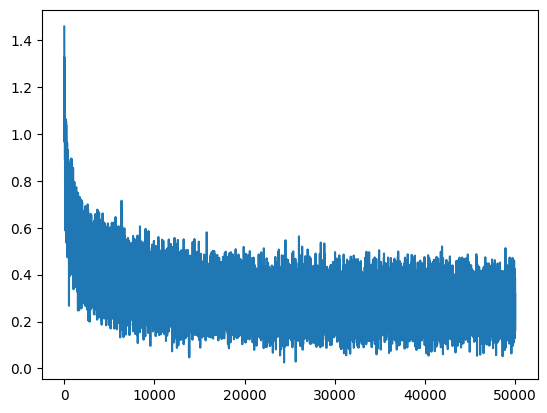

In [ ]:
plt.plot(steps, lossi)

**The validation set delivers a
loss function comparable with the training loss
This typically happens when the model underfits**


In [ ]:
emb = C[X_val]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y_val)  # Use the same indices for targets
loss.item()

2.3552803993225098

### How does the trained embedding look like?

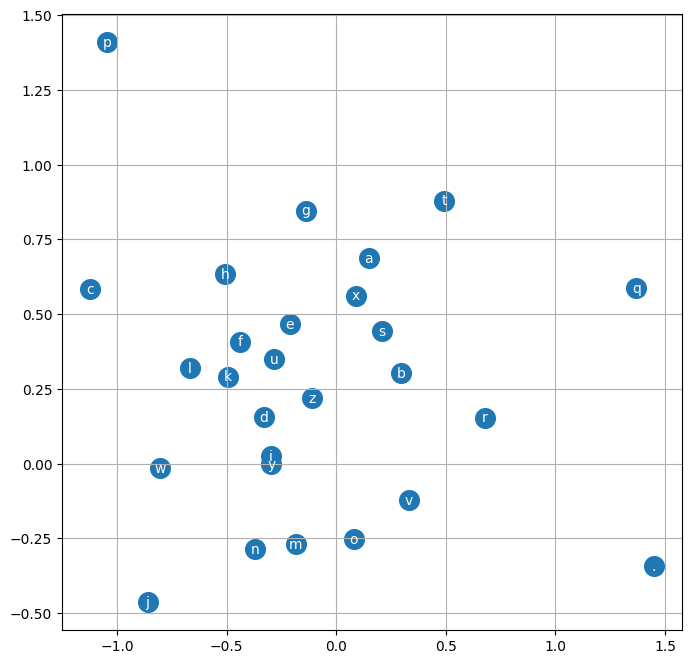

In [ ]:
plt.figure(figsize = (8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s = 200)
for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha = "center", va = "center", color = "white")
plt.grid("minor")

## How to sample from the model:

In [ ]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor(context)]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

    print(''.join(itos[i] for i in out))

m
mo
mon
mona
m
ma
may
maya
mayah
s
se
see
m
ma
mad
mady
madyn
a
al
ala
alay
alayn
alayna
r
ru
rut
ruth
d
dr
drl
drle
drlei
drleig
drleigh
e
el
ele
eled
eledy
eledye
i
ii
iil
iile
iiley
iileyg
iileyga
iileygan
iileygane
iileyganel
iileyganell
iileyganelle
e
el
eli
elie
elies
eliest
eliesta
eliestac
eliestaca
eliestacan
eliestacanl
eliestacanle
eliestacanlei
eliestacanleig
eliestacanleigh
m
ma
mal
mala
malai
malaia
n
no
nos
noso
nosor
nosorg
nosorgi
nosorgie
s
sh
shi
shir
shira
shirae
shirael
shiraely
j
ju
jul
juli
julis
julise
julisel
julisely
juliselyn
juliselynn
n
no
nov
nova
noval
novaly
novalyn
b
br
bre
bren
brenc
brence
r
ry
ryy
ryyl
ryyle
ryylen
ryylene
e
el
eli
k
ka
kay
kayl
kayle
kayley
kayleya
k
ky
kyl
kyle
kylei
kyleig
kyleigh
kyleigha
kyleighan
kyleighana
kyleighanaa
kyleighanaad
kyleighanaady
kyleighanaadyl
kyleighanaadyly
kyleighanaadylyn
kyleighanaadylynn


# Assignment:

I attempted to fine-tune the model with the goal of reducing the validation loss below 2.1. The assignment allows for a few strategies to achieve this, including:  
- Increasing the embedding dimension (since one issue with the Bengio model is the potential underutilization of the embedding space).  
- Expanding the context size (e.g., from 3 to 4).  
- Implementing a learning rate decay strategy.  
- Adding or reshaping layers.

---

# Modifications:

- I added an additional layer with the ReLU activation function to improve the non-linearity of the model.  
- I made the code less hardcoded than the original tutorial, allowing for easier changes to hyperparameters.  
- Instead of using a single hidden layer of size 200, I opted for two layers: one of size 200 and the second of size 100. This approach aimed to increase the depth of the network, which seemed a more promising strategy than simply enlarging a single layer.

---

# Results:

Unfortunately, I was unable to reduce the validation loss below 2.1. After manually adjusting the learning rate and iterations four times, the best result I achieved was a slightly improved validation loss of 2.30, compared to 2.35 in the original model.


In [ ]:
# Creation of the dataset:

block_size_op = 4
X_new, Y_new = [], []
length = len(words)


for w in words:
    context = [0]* block_size_op
    for ch in w + '.':
        ix = stoi[ch]
        X_new.append(context)
        Y_new.append(ix)
        context = context[1:] + [ix]

X_new = torch.tensor(X_new)
Y_new  = torch.tensor(Y_new)
print(X_new.shape, Y_new.shape)

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
X_train, Y_train = X_new[:n1], Y_new[:n1]
X_val, Y_val = X_new[n1:n2], Y_new[n1:n2]
X_test, Y_test = X_new[n2:], Y_new[n2:]

X_train.shape



torch.Size([228146, 4]) torch.Size([228146])


torch.Size([25626, 4])

### Visualize some dataset

In [ ]:
# Print a few examples of the dataset to verify correct creation
for i in range(5):  # Print the first 5 samples
    print(f"X[{i}]: {X_train[i]} -> Y[{i}]: {Y[i]}")


X[0]: tensor([0, 0, 0, 0]) -> Y[0]: 20
X[1]: tensor([0, 0, 0, 5]) -> Y[1]: 1
X[2]: tensor([ 0,  0,  5, 12]) -> Y[2]: 21
X[3]: tensor([ 0,  5, 12,  9]) -> Y[3]: 18
X[4]: tensor([ 5, 12,  9,  1]) -> Y[4]: 5


In [ ]:
block_size_op = 4 # Expand the number of letters to condition on!
emb_dim = 40
hidden1 = 200 # (100,50) seem to be promising
hidden2 = 100


# parameters:
lr = 0.1
batch_size = 64
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, emb_dim), generator=g)
W1 = torch.randn((block_size_op * emb_dim, hidden1), generator=g)
b1 = torch.randn(hidden1, generator=g)
W2 = torch.randn((hidden1, hidden2), generator=g)
b2 = torch.randn(hidden2, generator=g)
W3 = torch.randn((hidden2, 27)) # swapped
b3 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2, W3, b3]


In [ ]:
for p in parameters:
  p.requires_grad = True

In [134]:
lossi = []  # To store loss values
steps = []

In [131]:
import torch
import torch.nn.functional as F


lr = 0.05
iterations = 500000
batch_size = 64



for i in range(iterations):
    # Forward pass
    ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)# Randomly sample a batch
    embstar = C[X_train[ix]]
    h = F.leaky_relu(embstar.view(batch_size, -1) @ W1 + b1, negative_slope = 0.01) # W1 batch_size*hidden_1 + b1 hidden_1
    z = F.tanh(h @ W2 + b2) #W2star (batch_size, hidden1) *() hidden1, hidden2)  + hidden2 -> (64 , hidden2)
    logits = z @ W3 + b3 # (batch_size, hidden2) * (hidden2, 27) + 27
    loss = F.cross_entropy(logits, Y_train[ix])  # Use the same indices for targets

    # Backward pass
    for p in parameters:
        p.grad = None  # Clear gradients
    loss.backward()

    #Track stats
    #lri.append(lr)
    steps.append(i)
    lossi.append(loss.log10().item())

    #Learning rate decay:
    if i % 10000 == 0:
      lr = lr/10;


    # Update parameters
    for p in parameters:
        p.data += -lr * p.grad

# Print final loss
print("Final loss:", loss.item())


Final loss: 2.1942665576934814


## Validation loss

In [132]:
ix = torch.randint(0, X_val.shape[0], (batch_size,), generator=g)# Randomly sample a batch
emb = C[X_val[ix]]
h = F.leaky_relu(emb.view(batch_size, -1) @ W1 + b1, negative_slope = 0.01) # W1 batch_size*hidden_1 + b1 hidden_1
z = torch.tanh(h @ W2 + b2) #W2star (batch_size, hidden1) *() hidden1, hidden2)  + hidden2 -> (64 , hidden2)
logits = z @ W3 + b3
loss = F.cross_entropy(logits, Y_val[ix])  # Use the same indices for targets
loss.item()

2.308105707168579

## Sampling from this new model

In [136]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size_op
  while True:
    #emb = C[torch.tensor(context)]
    #h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    #logits = h @ W2 + b2

    emb = C[torch.tensor(context)]
    h = F.leaky_relu(emb.view(1, -1) @ W1 + b1, negative_slope = 0.01) # W1 1*hidden_1 + b1 hidden_1
    z = F.tanh(h @ W2 + b2) #W2star (1, hidden1) *() hidden1, hidden2)  + hidden2 -> (1 , hidden2)
    logits = z @ W3 + b3 # (1, hidden2) * (hidden2, 27) + 27
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break

    print(''.join(itos[i] for i in out))

m
mo
mor
mora
k
km
kmy
kmya
kmyay
s
se
see
seel
n
nd
ndy
ndyr
ndyri
ndyria
ndyriah
r
re
ren
renh
renhr
j
je
jen
jeng
jengr
jengrn
jengrno
jengrnom
a
ad
ade
adel
adely
adelyn
e
el
eli
elii
eliih
eliihn
eliihnn
eliihnni
eliihnnio
eliihnnion
eliihnnione
eliihnnionet
e
ed
ede
edel
c
ca
car
carr
carri
carria
carrian
carriann
carrianne
t
tu
tuk
tukm
tukmo
tukmor
tukmory
tukmorye
tukmoryel
n
no
nos
nosh
noshe
nosheg
noshegn
g
ga
gah
gahv
gahve
gahven
s
sa
sav
savi
j
jo
jos
jose
josel
josell
joselle
j
je
jet
jett
jetta
jettac
jettaca
jettacat
b
br
bre
bret
breth
brethd
r
ru
ruy
ruyi
ruyia
ruyial
ruyiall
ruyialli
ruyiallie
ruyiallieh
y
yk
yka
ykaa
m
mi
mis
misa
misan
misanu
misanue
misanuer
